# Visualisation et calcul d'un gradient adiabatique

Ce notebook permet:

    1. D'explorer des données météorologiques
    2. Calculer un gradient adiabatique


In [58]:
# Importe les packages utilisés dans ce code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import linregress
from windrose import WindroseAxes

sns.set(style="whitegrid")

In [48]:
# Accède aux données format CSV et les enregistre comme Dataframe Pandas dans un dictionnaire.
data = {
    "MontStAnne": pd.read_csv(r"C:\Users\masl0012\OneDrive - UQAR\Cours UQAR\Stage 2\TP3\WxStationAvQ_PetitMontSaintAnne_2024-2025.csv", parse_dates=["Date"], index_col="Date"),
    "ErnestLaforce": pd.read_csv(r"C:\Users\masl0012\OneDrive - UQAR\Cours UQAR\Stage 2\TP3\WxStationAvQ_ErnestLaforce_2024-2025.csv", parse_dates=["Date"], index_col="Date"),
    "MontAlbert": pd.read_csv(r"C:\Users\masl0012\OneDrive - UQAR\Cours UQAR\Stage 2\TP3\WxStationAvQ_GiteMontAlbert _2024-2025.csv", parse_dates=["Date"], index_col="Date"),
}

# Identifie l'élévation associé à chaque station
elevations = {"MontStAnne": 1145, "ErnestLaforce": 600, "MontAlbert": 230}


In [49]:
# Function qui permet de choisir quel type de d'opération sera apppliquée en fonction de la variable sélectionnée. 
# Permet également de sélectionner les quantiles utilisés pour générer les barres d'erreurs. 

def resample_with_quantiles(series, interval, variable, q_low=0.25, q_high=0.75):
    resample_methods = {
    "TAx": "mean",
    "TAn": "mean",
    "TAm": "mean",
    "TAi": "mean",
    "HAi": "mean",
    "NSi": "last",
    "PT": "sum",
    "PAi": "mean",
    "VVI": "mean",
    "VVxi": "mean"}

    method = resample_methods.get(variable, "mean")
    grouped = series.resample(interval)

    if method == "sum":
        agg = grouped.sum()
    elif method == "max":
        agg = grouped.max()
    elif method == "min":
        agg = grouped.min()
    elif method == "last":
        agg = grouped.last()
    elif method == "mean":
        agg = grouped.mean()

    q_low_series = grouped.quantile(q_low)
    q_high_series = grouped.quantile(q_high)

    return agg, q_low_series, q_high_series

In [50]:
# Fonction qui applique resample_with_quantile et qui ordonne les données

def compute_mean_and_quantile(df_dict, elevations, variable, interval, q_low, q_high):
    results = []
    for name, df in df_dict.items():
        if variable not in df.columns:
            continue
        mean, q_low_series, q_high_series = resample_with_quantiles(df[variable], interval, variable, q_low=q_low, q_high=q_high)
        results.append((name, elevations[name], mean, q_low_series, q_high_series,))

    return results


In [55]:
#Fonction qui produit le graphique intéractif et calcul le gradient adiabatique

def interactive_combined_plot(df_dict, elevations):
    station_names = list(df_dict.keys())
    variables = sorted({col for df in df_dict.values() for col in df.columns})

    variable_dropdown = widgets.Dropdown(options=["TAm", "TAx", "TAn", "HAi", "NSi", "PAi", "VVi", "VVxi"] , description="Variable:", value="TAm")
    interval_dropdown = widgets.Dropdown(
        options=["1h", "1D", "7D", "1ME"],
        value="1D",
        description="Interval:"
    )
    
    # Determine overall min and max date
    min_date = min(df.index.min() for df in df_dict.values())
    max_date = max(df.index.max() for df in df_dict.values())

    start_date_picker = widgets.DatePicker(
        description="Start:",
        value=min_date.to_pydatetime().date(),
        disabled=False
    )
    end_date_picker = widgets.DatePicker(
        description="End:",
        value=max_date.to_pydatetime().date(),
        disabled=False
    )

    reset_button = widgets.Button(
        description="Reset full range",
        button_style="info",
        icon="refresh"
    )

    def reset_dates(_):
        start_date_picker.value = min_date.to_pydatetime().date()
        end_date_picker.value = max_date.to_pydatetime().date()

    reset_button.on_click(reset_dates)

    quantile_options = {
    "25-75%": (0.25, 0.75),
    "5-95%": (0.05, 0.95)
    }

    quantile_dropdown = widgets.Dropdown(
        options=quantile_options,
        value=(0.25, 0.75),
        description="Quantile:"
    )

    
    export_button = widgets.Button(
        description="Export SVG", button_style="success", icon="download"
    )
    export_output = widgets.Output()
    last_fig = {"fig": None}


    def update_plot(variable, interval, start_date, end_date, quantile):
        q_low, q_high = quantile  # unpack tuple
        
        # --- Compute lapse rate ---
        results = compute_mean_and_quantile(df_dict, elevations, variable, interval, q_low=q_low, q_high=q_high)

        # Merge for common timeline
        merged = pd.concat(
            {name: mean for name, _, mean, _, _, in results}, axis=1
        ).dropna()

        # --- Filter by date range ---
        if start_date and end_date:
            merged = merged.loc[str(start_date):str(end_date)]
            results = [
                (name, elev, mean.loc[str(start_date):str(end_date)],
                 q_low_series.loc[str(start_date):str(end_date)],
                 q_high_series.loc[str(start_date):str(end_date)],
                )
                for (name, elev, mean, q_low_series, q_high_series) in results
            ]

        # --- Plot setup ---
        fig, axes = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'width_ratios': [2, 1]})
        
        # Left: Time series
        for name, elev, mean, q_low_series, q_high_series in results:
            axes[0].plot(mean.index, mean.values, label=name)
            axes[0].fill_between(mean.index, q_low_series.values, q_high_series.values, alpha=0.2)
        
        axes[0].set_title(f"{variable} over Time ({interval})")
        axes[0].set_ylabel(variable)
        axes[0].legend()
        axes[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

        # Right: Temperature vs altitude
        mean_temps = [m.mean() for _, _, m, _, _, in results]
        q_low_temps = [m.quantile(q_low) for _, _, m, _, _, in results]
        q_high_temps = [m.quantile(q_high) for _, _, m, _, _, in results]
        elevs = [elevations[name] for name, _, _, _, _, in results]
        
        axes[1].errorbar(mean_temps, elevs,
                         xerr=[np.array(mean_temps) - np.array(q_low_temps),
                               np.array(q_high_temps) - np.array(mean_temps)],
                         fmt='o', capsize=4)
        axes[1].set_title("Temperature vs Altitude")
        axes[1].set_xlabel(f"Mean {variable}")
        axes[1].set_ylabel("Elevation (m)")
        
        # --- Compute lapse rate (linear fit) ---
        from numpy.polynomial.polynomial import polyfit
        
        # fit elev = f(temp) to get deltaT / deltaZ
        coeffs = polyfit(mean_temps, elevs, 1)  # elev = a*temp + b
        slope = coeffs[1]  # dElevation/dTemp
        lapse_rate = 100 / slope  # °C per 100 m
        x_fit = np.linspace(min(mean_temps), max(mean_temps), 100)
        y_fit = coeffs[0] + coeffs[1]*x_fit
        axes[1].plot(x_fit, y_fit, 'r--', label=f"LR: {lapse_rate:.2f} °C/100m")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def export_svg(_):
        with export_output:
            export_output.clear_output()
            if last_fig["fig"] is not None:
                filename = "interactive_plot.svg"
                last_fig["fig"].savefig(filename, format="svg")
                print(f"✅ Figure exported as {filename}")
            else:
                print("⚠️ No figure to export yet.")

    export_button.on_click(export_svg)

        
    ui = widgets.VBox([
        widgets.HBox([variable_dropdown, interval_dropdown, quantile_dropdown]),
        widgets.HBox([start_date_picker, end_date_picker, reset_button, export_button]),
        export_output
    ])

    out = widgets.interactive_output(
        update_plot,
        {
            "variable": variable_dropdown,
            "interval": interval_dropdown,
            "start_date": start_date_picker,
            "end_date": end_date_picker,
            "quantile": quantile_dropdown
        }
    )

    display(ui, out)


In [56]:
interactive_combined_plot(data, elevations)


Output()

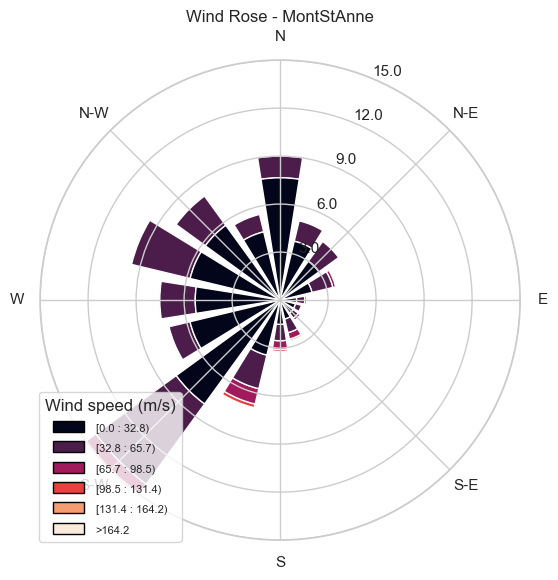

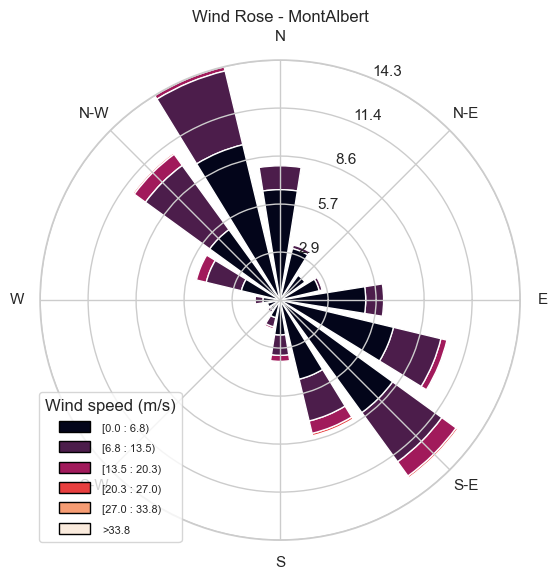

In [59]:
for station_name, df in data.items():
    if "VVi" not in df.columns:
        continue
    ws = df["VVi"]
    wd = df["VDi"]
    
    fig = plt.figure(figsize=(6,6))
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend(title="Wind speed (m/s)")
    plt.title(f"Wind Rose - {station_name}")
    plt.show()